Loading dataset: /content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv
Original shape: (1693, 19)
✅ Model trained successfully
Calculating SHAP values...

 📊 BẢNG TÓM TẮT GIÁ TRỊ SHAP (Mean Absolute Value)
             Feature  Mean_Abs_SHAP
  Gas injection rate       7.445482
Annulus pressure min       4.369668
               T max       3.504634
 Buffer pressure max       1.870517
               T min       1.612402
   Flow pressure min       1.565064
 Buffer pressure min       1.553919
Annulus pressure max       0.595338
   Flow pressure max       0.443313
               Choke       0.190145
            Downtime       0.045189



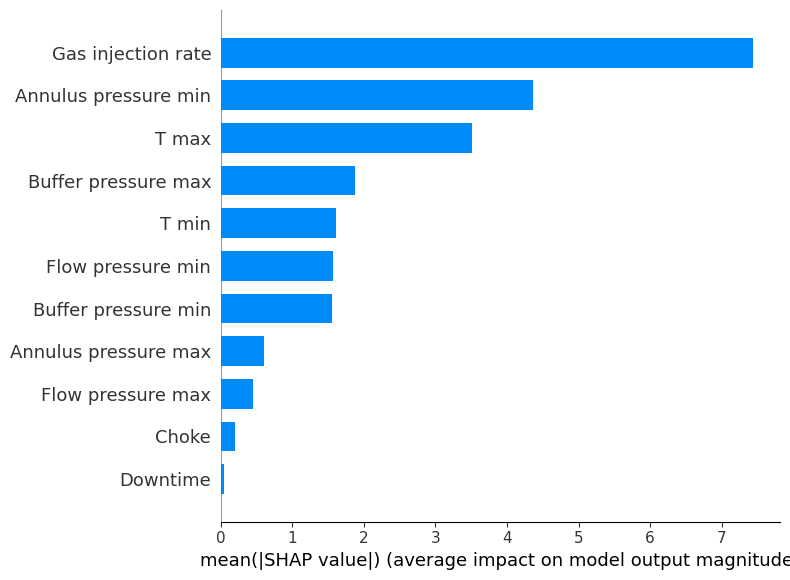

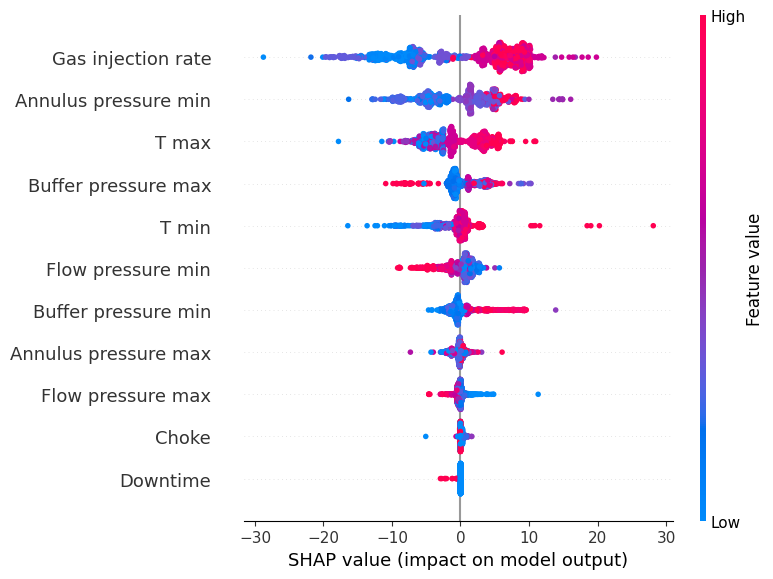

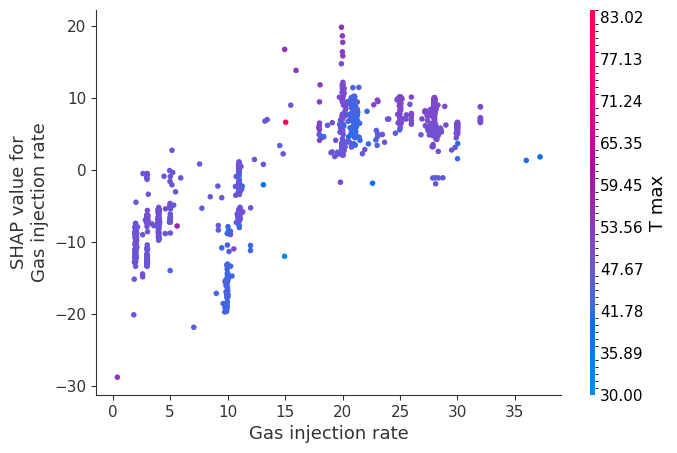

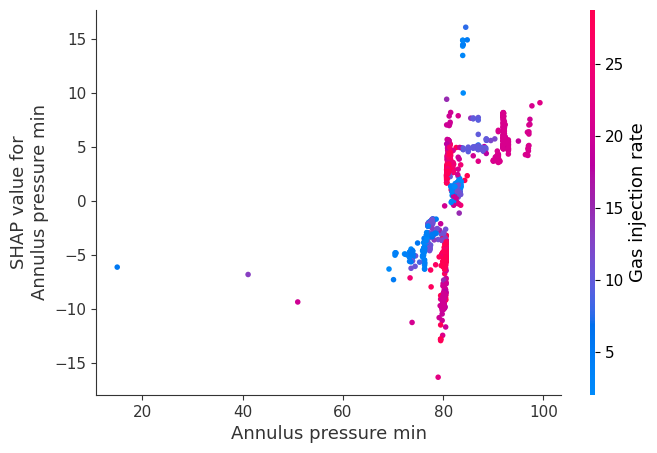

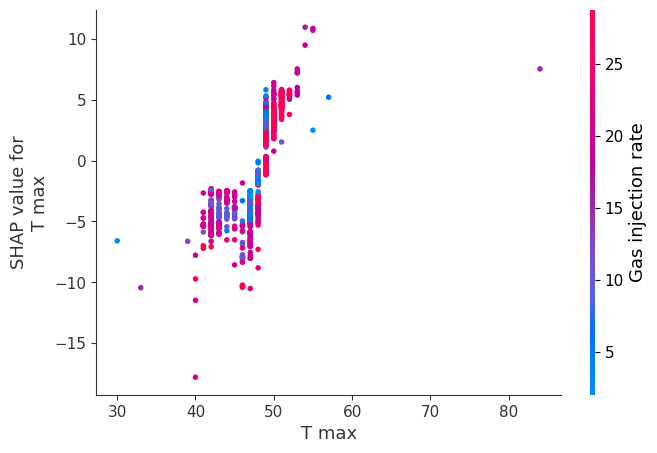

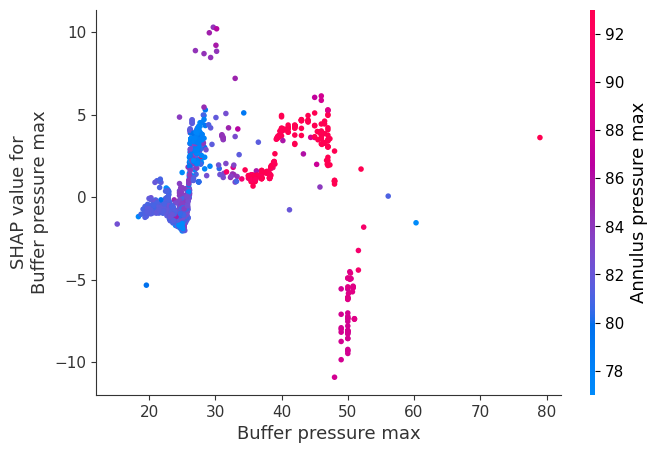

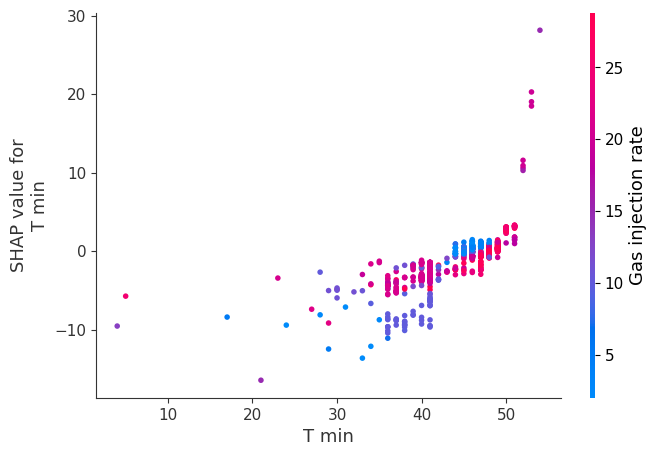


🔎 Explaining sample index 10:


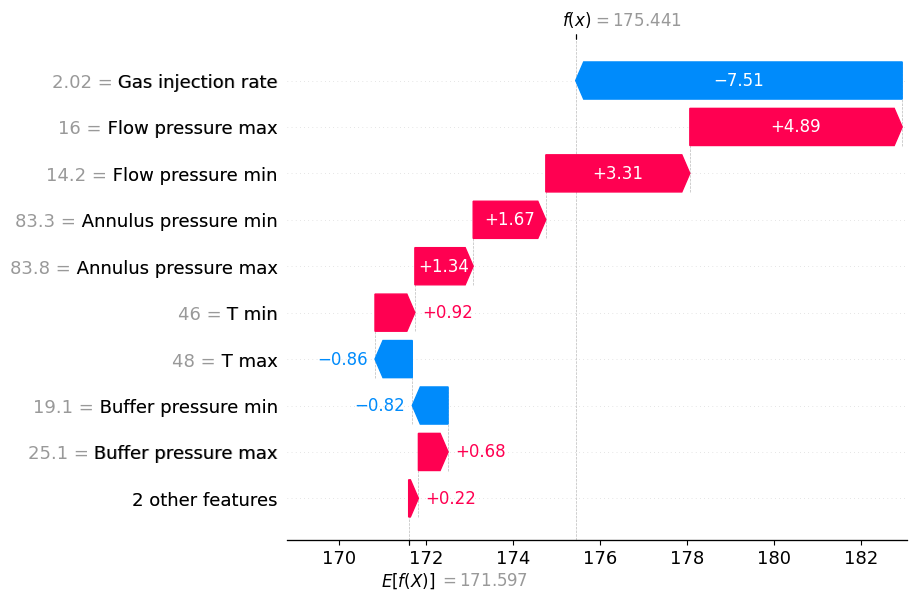

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# 1️⃣ Tải và chuẩn bị dữ liệu
# -------------------------------------------------------
file_path = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
print(f"Loading dataset: {file_path}")

df = pd.read_csv(file_path)
print("Original shape:", df.shape)

# Loại bỏ cột Date (không có giá trị mô hình)
if 'Date' in df.columns:
    df = df.drop(columns=['Date'])
if 'Potential oil production' in df.columns:
    df = df.drop(columns=['Potential oil production'])
if 'Potential liquid production' in df.columns:
    df = df.drop(columns=['Potential liquid production'])
if 'Oil cut' in df.columns:
    df = df.drop(columns=['Oil cut'])
#if 'Water cut' in df.columns:
#    df = df.drop(columns=['Water cut'])
if 'Qoil' in df.columns:
    df = df.drop(columns=['Qoil'])
if 'Qgas' in df.columns:
    df = df.drop(columns=['Qgas'])
if 'Gas factor' in df.columns:
    df = df.drop(columns=['Gas factor'])
if 'Water cut' in df.columns:
    df = df.drop(columns=['Water cut'])

# Xử lý giá trị thiếu
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['Qliq'])  # cần target

# <<< SỬA LỖI TIỀM NĂNG: Xử lý cột 'Downtime' (nếu có) >>>
# Giả sử cột Downtime là object (ví dụ '01:30'), cần chuyển đổi
# Nếu nó đã là số, .median() sẽ hoạt động. Nếu là object, nó sẽ bị bỏ qua.
# Hãy thử chuyển đổi nó sang số một cách an toàn
for col in df.columns:
    if df[col].dtype == 'object':
        # Cố gắng chuyển đổi sang số, nếu thất bại, giữ nguyên
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except ValueError:
            pass # Bỏ qua nếu không thể chuyển đổi

df = df.fillna(df.median(numeric_only=True))
# Sau khi fillna, có thể vẫn còn cột object, loại bỏ chúng
df = df.select_dtypes(include=[np.number])


# -------------------------------------------------------
# 2️⃣ Chia dữ liệu huấn luyện và thử nghiệm
# -------------------------------------------------------
X = df.drop(columns=['Qliq'])
y = df['Qliq']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Lấy lại tên cột sau khi scale (vì X_train có thể đã bị thay đổi)
X_train_cols = X.columns
X_test_cols = X.columns

# -------------------------------------------------------
# 3️⃣ Huấn luyện mô hình mẫu (Random Forest)
# -------------------------------------------------------
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)
print("✅ Model trained successfully")

# -------------------------------------------------------
# 4️⃣ Phân tích SHAP
# -------------------------------------------------------
print("Calculating SHAP values...")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

# -------------------------------------------------------
# ⭐️ BỔ SUNG: In Bảng Tóm tắt SHAP ⭐️
# -------------------------------------------------------
print("\n" + "="*40)
print(" 📊 BẢNG TÓM TẮT GIÁ TRỊ SHAP (Mean Absolute Value)")
print("="*40)

# 1. Tính giá trị SHAP trung bình tuyệt đối cho từng đặc trưng
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 2. Tạo DataFrame để hiển thị
shap_summary_df = pd.DataFrame({
    'Feature': X_train_cols,  # Sử dụng tên cột đã lưu
    'Mean_Abs_SHAP': mean_abs_shap
})

# 3. Sắp xếp theo tầm quan trọng giảm dần
shap_summary_df = shap_summary_df.sort_values(by='Mean_Abs_SHAP', ascending=False)

# 4. In toàn bộ bảng (sử dụng to_string để đảm bảo in tất cả)
print(shap_summary_df.to_string(index=False))
print("="*40 + "\n")

# -------------------------------------------------------
# 5️⃣ Biểu đồ tổng hợp SHAP
# -------------------------------------------------------
# (Giữ nguyên, sử dụng X_train GỐC (chưa scale) để hiển thị giá trị)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)

# Biểu đồ phân tán chi tiết
shap.summary_plot(shap_values, X_train, show=True)

# -------------------------------------------------------
# 6️⃣ Phân tích phụ thuộc chi tiết của từng đặc trưng
# -------------------------------------------------------
top_features = np.argsort(np.abs(shap_values).mean(axis=0))[-5:][::-1]
top_cols = X_train_cols[top_features]

for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train, show=True)

# -------------------------------------------------------
# 7️⃣ Giải thích cụ thể cho 1 mẫu bất kỳ
# -------------------------------------------------------
sample_index = 10
sample = X_test_scaled[sample_index:sample_index+1]
sample_original = X_test.iloc[sample_index]

print(f"\n🔎 Explaining sample index {sample_index}:")
shap_value_sample = explainer.shap_values(sample)

# Lấy base_value từ explainer
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0] # Xử lý nếu base_value là mảng

shap.waterfall_plot(shap.Explanation(
    values=shap_value_sample[0],
    base_values=base_value,
    data=sample_original,
    feature_names=X_test_cols
))
plt.show()